In [1]:
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import statsmodels.tsa.api as smt
from statsmodels.tsa.stattools import adfuller
import matplotlib.pyplot as plt
from scipy.stats import boxcox
%matplotlib inline
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error

In [2]:
def test_stationarity(timeseries):
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for [key, value] in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [3]:
def tsplot(y, lags=None, figsize=(14, 8), style='bmh'):
    test_stationarity(y)
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):
        plt.figure(figsize=figsize)
        layout = (4, 1)
        ts_ax = plt.subplot2grid(layout, (0, 0), rowspan=2)
        acf_ax = plt.subplot2grid(layout, (2, 0))
        pacf_ax = plt.subplot2grid(layout, (3, 0))

        y.plot(ax=ts_ax, color='blue', label='Or')
        ts_ax.set_title('Original')

        smt.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.05)
        smt.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.05)

        plt.tight_layout()
    return

In [4]:
def double_ema(series, alpha, beta):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
    return pd.Series(result)

In [5]:
def plot_dema(alpha, beta):
    dema = double_ema(sales_of_company_x["Count"], alpha, beta)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(sales_of_company_x["Count"], color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [6]:
sales_of_company_x = pd.read_csv("Series/monthly-sales-of-company-x-jan-6.csv")
robberies_in_boston = pd.read_csv("Series/monthly-boston-armed-robberies-j.csv")
airlines_passengers = pd.read_csv("Series/international-airline-passengers.csv")
mean_monthly_temp = pd.read_csv("Series/mean-monthly-air-temperature-deg.csv")
dowjones_closing = pd.read_csv("Series/weekly-closings-of-the-dowjones-.csv")
female_births = pd.read_csv("Series/daily-total-female-births-in-cal.csv")

In [7]:
all_series = {
    "Monthly sales of company X": sales_of_company_x["Count"],
    "Monthly Boston armed robberies": robberies_in_boston["Count"],
    "International airline passengers: monthly totals in thousands": airlines_passengers["Count"],
    "Mean monthly air temperature (Deg. F) Nottingham Castle": mean_monthly_temp["Deg"],
    "Weekly closings of the Dow-Jones industrial average": dowjones_closing["Close"],
    "Daily total female births in California": female_births["Count"]
}

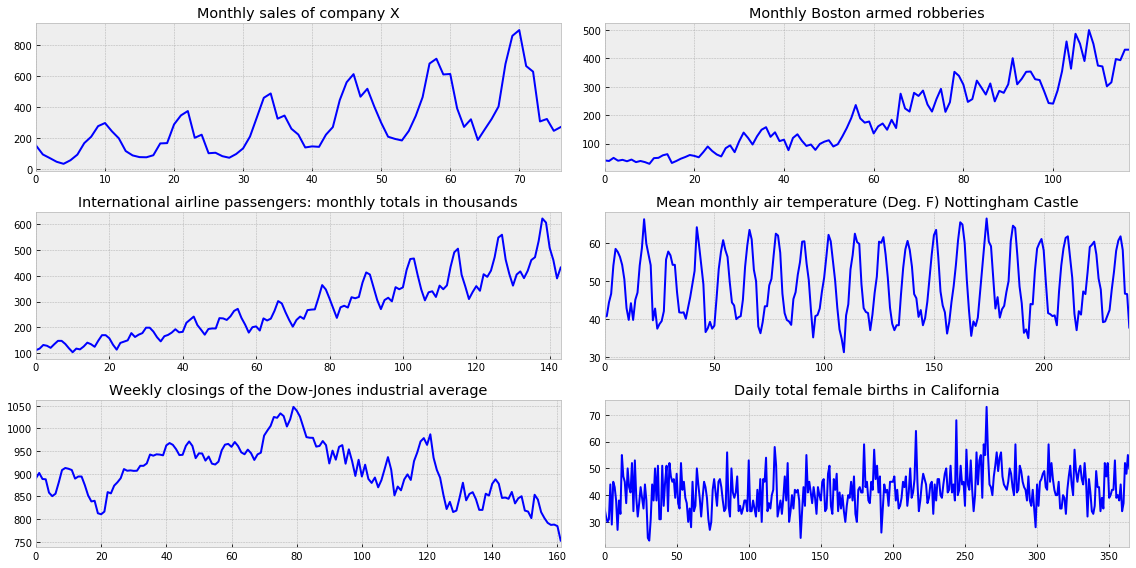

In [8]:
with plt.style.context('bmh'):
    plt.figure(figsize=(16, 8))
    layout = (3, 2)
    for i, key in enumerate(all_series.keys()):
        x = i % 2
        y = int((i - x) / 2)
        
        ts_ax = plt.subplot2grid(layout, (y, x))
        all_series[key].plot(ax=ts_ax, color='blue')
        ts_ax.set_title(key)
        
    plt.tight_layout()

In [9]:
poss_stat = []
for cur in all_series.keys():
    
    cur_res = adfuller(all_series[cur], autolag='AIC')[1]
    print(f'{cur} p-value: {cur_res}')
    if cur_res < 0.05:
        poss_stat.append(cur)
        print('\t\tPossibly stationary')

Monthly sales of company X p-value: 0.9888894205170052
Monthly Boston armed robberies p-value: 0.9942775638057231
International airline passengers: monthly totals in thousands p-value: 0.9918802434376409
Mean monthly air temperature (Deg. F) Nottingham Castle p-value: 0.016989030222608826
		Possibly stationary
Weekly closings of the Dow-Jones industrial average p-value: 0.6224548515589732
Daily total female births in California p-value: 5.2434129901498554e-05
		Possibly stationary


Потенциально стационарны температура в Ноттингеме и рождение девочек

Results of Dickey-Fuller Test:
Test Statistic                  -3.255492
p-value                          0.016989
#Lags Used                      14.000000
Number of Observations Used    225.000000
Critical Value (1%)             -3.459752
Critical Value (5%)             -2.874473
Critical Value (10%)            -2.573663
dtype: float64


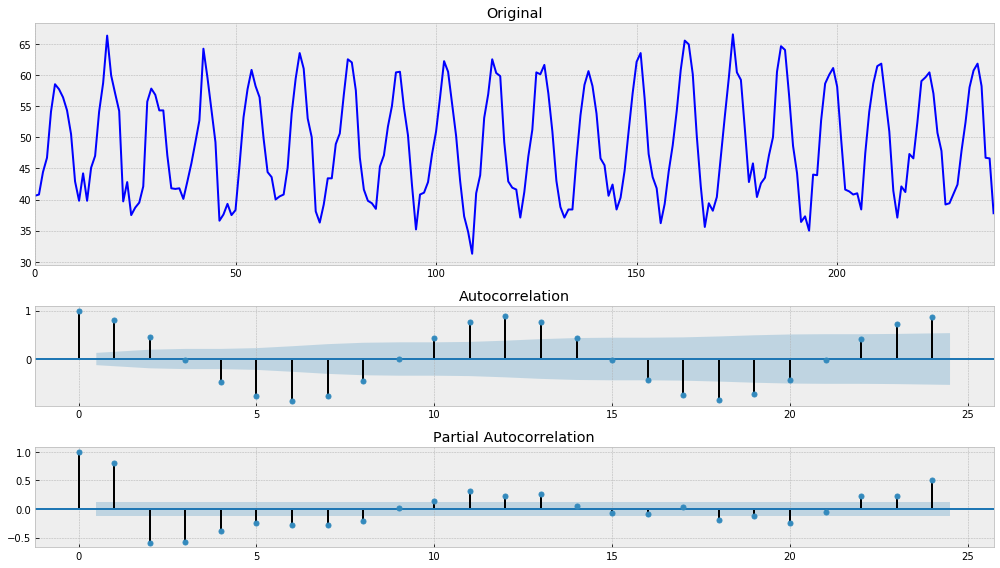

In [10]:
tsplot(all_series[poss_stat[0]])

Results of Dickey-Fuller Test:
Test Statistic                  -4.808291
p-value                          0.000052
#Lags Used                       6.000000
Number of Observations Used    358.000000
Critical Value (1%)             -3.448749
Critical Value (5%)             -2.869647
Critical Value (10%)            -2.571089
dtype: float64


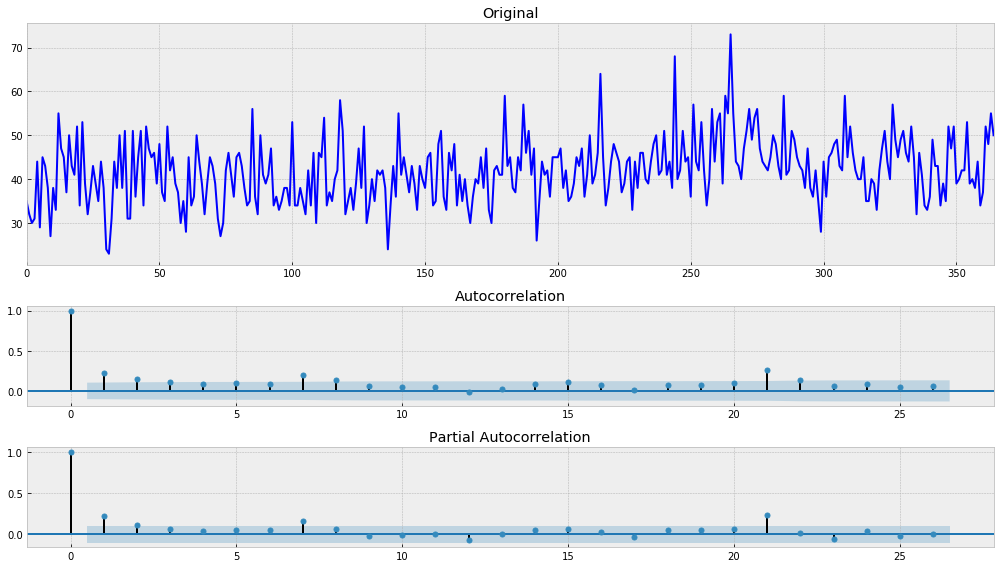

In [11]:
tsplot(all_series[poss_stat[1]])

In [26]:
#Custom train_test_split - just for fun))
def my_train_test_split(series, train_size=0.7, test_size=0.3, gen_val=False):
    ser_len = len(series)
    
    if gen_val:
        val_coef = 0.9
    else:
        val_coef = 1
        
    test_len = int(np.ceil(ser_len*test_size*val_coef))
    train_len = int(np.floor(ser_len*val_coef) - test_len)
    
    if gen_val:
        return series[:train_len], series[train_len:train_len+test_len], series[train_len+test_len:]
    else:
        return series[:train_len], series[train_len:train_len+test_len]

In [15]:
# Predicting DEMA values
def double_ema_predict(series, alpha, beta, n_preds):
    result = [series[0]]
    level, trend = series[0], series[1] - series[0]
    for n in range(1, len(series)):
        value = series[n]
        last_level, level = level, alpha*value + (1-alpha)*(level+trend)
        trend = beta*(level-last_level) + (1-beta)*trend
        result.append(level+trend)
        
    for i in range(n_preds):
        
        result.append(level+trend*i)
    return pd.Series(result)

In [17]:
#Plotting predicted values
def plot_predict_dema(series, alpha, beta, n_preds):
#     dema = double_ema(sales_of_company_x["Count"], alpha, beta)
    ser_len = len(series)
    
    test_size = n_preds / ser_len
    train_size = (ser_len-n_preds) / ser_len
    train, test = my_train_test_split(series, train_size=train_size, test_size=test_size)
    dema = double_ema_predict(train, alpha, beta, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(series, color='blue',label='original')
        plt.plot(dema, color='red', linewidth='4', label='DEMA')
        plt.title("alpha={}, beta={}".format(alpha, beta))
        plt.legend()

In [18]:
#Error function - takes vector & 2 time series for training & testing
def ema_mse(X, train, test):
    alpha, beta = X
    result = double_ema_predict(train, alpha, beta, len(test))
    preds = result[-len(test):]
    error = mean_squared_error(preds, test)
    return error

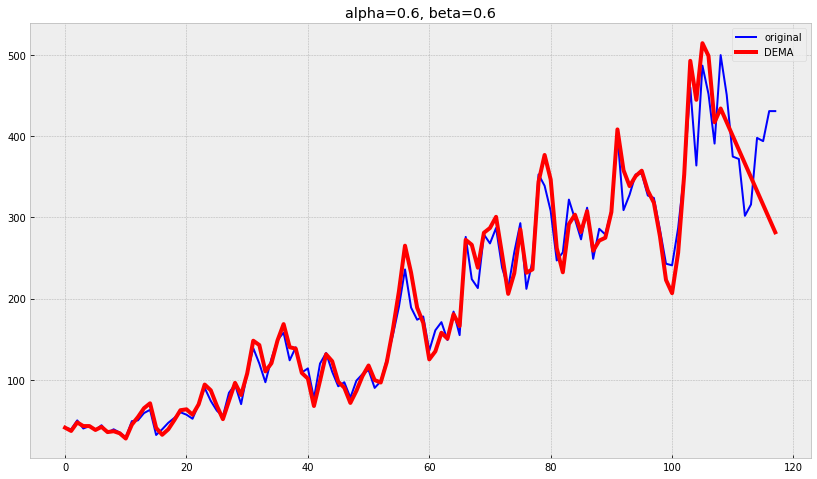

In [27]:
plot_predict_dema(np.array(all_series["Monthly Boston armed robberies"]), 0.6, 0.6, 10)

In [28]:
series = all_series["Monthly Boston armed robberies"]

In [29]:
train, test = my_train_test_split(series)

In [30]:
opt = minimize(ema_mse, x0=[0,0], args=(train, test), method="L-BFGS-B", bounds = ((0, 1), (0, 1)))

In [31]:
opt

      fun: 3101.122078841995
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([0.0037744 , 0.00127329])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 99
      nit: 23
   status: 0
  success: True
        x: array([0.57045605, 0.05561223])

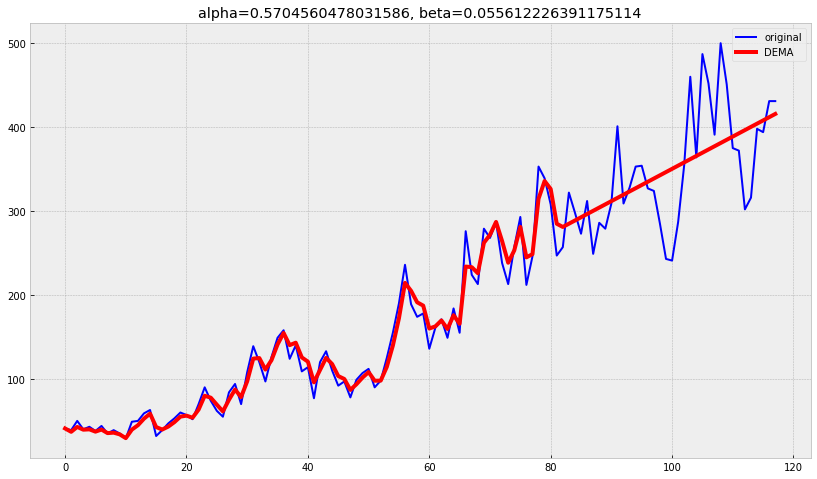

In [32]:
# dema = double_ema_predict(train, opt.x[0], opt.x[1], len(test))
# with plt.style.context('bmh'):
#     plt.figure(figsize=(14, 8))
#     plt.plot(all_series["Monthly Boston armed robberies"], color='blue',label='original')
#     plt.plot(dema, color='red', linewidth='4', label='DEMA')
#     plt.title("alpha={}, beta={}".format(opt.x[0], opt.x[1]))
#     plt.legend()
plot_predict_dema(series, opt.x[0], opt.x[1], len(test))

## ИМХО, угадать тренд получилось. Попробуем еще раз на ряде с возрастающей дисперсией

In [33]:
series = all_series["International airline passengers: monthly totals in thousands"]


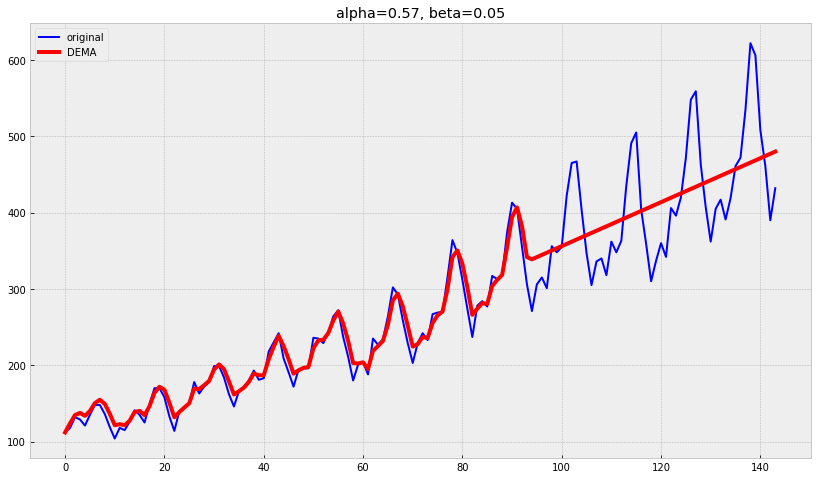

In [34]:
plot_predict_dema(series, 0.57, 0.05, 50)

In [35]:
train, test = my_train_test_split(series)
opt = minimize(ema_mse, x0=[0,0], args=(train, test), method="L-BFGS-B", bounds = ((0, 1), (0, 1)))
opt

      fun: 4483.946919230316
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([-318.90022001, -183.1622285 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 87
      nit: 16
   status: 0
  success: True
        x: array([0.91222108, 0.96683126])

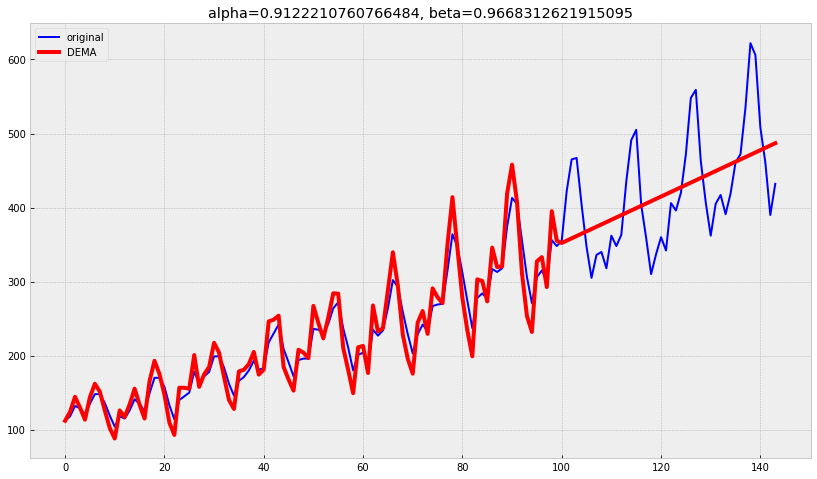

In [36]:
plot_predict_dema(series, opt.x[0], opt.x[1], len(test))

# Triple Exponential Mean Average

In [37]:
def initial_trend(series, season_len):
    return sum([float(series[i + season_len] - series[i]) / season_len]) / season_len

In [38]:
def initial_seasonal_components(series, slen):
    seasonals = {}
    season_averages = []
    n_seasons = int(len(series)/slen)
    # compute season averages
    for j in range(n_seasons):
        season_averages.append(sum(series[slen*j:slen*j+slen])/float(slen))
    # compute initial values
    for i in range(slen):
        sum_of_vals_over_avg = 0.0
        for j in range(n_seasons):
            sum_of_vals_over_avg += series[slen*j+i]-season_averages[j]
        seasonals[i] = sum_of_vals_over_avg/n_seasons
    return seasonals

In [39]:
def triple_exponential_smoothing(series, slen, alpha, beta, gamma, n_preds):
    result = []
    seasonals = initial_seasonal_components(series, slen)
    for i in range(len(series)+n_preds):
        if i == 0: # initial values
            smooth = series[0]
            trend = initial_trend(series, slen)
            result.append(series[0])
            continue
        if i >= len(series): # we are forecasting
            m = i - len(series) + 1
            result.append((smooth + m*trend) + seasonals[i%slen])
        else:
            val = series[i]
            last_smooth, smooth = smooth, alpha*(val-seasonals[i%slen]) + (1-alpha)*(smooth+trend)
            trend = beta * (smooth-last_smooth) + (1-beta)*trend
            seasonals[i%slen] = gamma*(val-smooth) + (1-gamma)*seasonals[i%slen]
            result.append(smooth+trend+seasonals[i%slen])
    return result

In [40]:
def plot_tema(alpha, beta, gamma, period, ser=sales_of_company_x["Count"], ser_to_plot=sales_of_company_x["Count"], n_preds=24):
    tema = triple_exponential_smoothing(ser, period, alpha, beta, gamma, n_preds)
    with plt.style.context('bmh'):
        plt.figure(figsize=(14, 8))
        plt.plot(ser_to_plot, color='blue',label='original')
        plt.plot(tema, color='red', linewidth='4', label='TEMA')
        plt.title("alpha={}, beta={}, gamma={}, period={}".format(alpha, beta, gamma, period))
        plt.legend()

In [41]:
# TEMA mse function
def tema_mse(X, train, test, n_period):
    alpha, beta, gamma = X 
#     n_period = int(n_period)
    result = triple_exponential_smoothing(train, n_period, alpha, beta, gamma, len(test))
    predictions = result[-len(test):]
    error = mean_squared_error(predictions, test)
    return error

In [42]:
series = all_series["International airline passengers: monthly totals in thousands"]
train, test = my_train_test_split(series)
# train = series[:-10]
# test = series[-10:]

In [43]:
# Searching for period. If you make mistake 0 you can get 13 month period and will live with moon calendar)) 
best_fun = 100000000000
for i in range(1, 30):
    opt = minimize(tema_mse, x0=[0,0,0], args=(train, test, i), method='L-BFGS-B', bounds = ((0, 1), (0, 1), (0, 1)))
#     print(i, ':', opt.fun)
    if opt.fun < best_fun:
        best_fun = opt.fun
        best_opt = opt
        best_i = i
# , method="L-BFGS-B"
print(best_i, ':', best_opt)


12 :       fun: 1766.3854231474606
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([-5.54318444e+02,  2.00088834e-03,  0.00000000e+00])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 64
      nit: 10
   status: 0
  success: True
        x: array([1.        , 0.03577353, 1.        ])


In [44]:
opt = best_opt

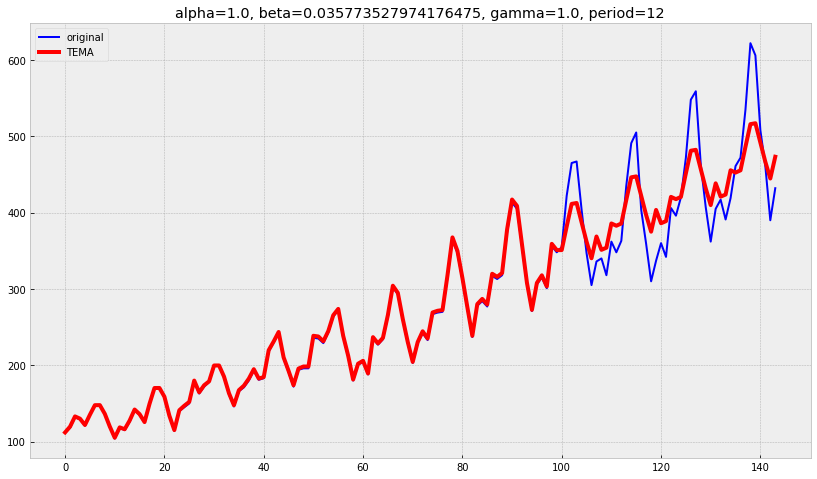

In [45]:
plot_tema(opt.x[0], opt.x[1], opt.x[2], best_i, train, series, len(test))

# Тренд угадан верно, предсказания колеблятся с линией партии, но полностью ей не соответствуют. Попробуем убрать рост дисперсии

In [46]:
series = boxcox(series, 0)

In [47]:
train, test = my_train_test_split(series)

In [48]:
best_fun = 100000000000
for i in range(1, 30):
    opt = minimize(tema_mse, x0=[0,0,0], args=(train, test, i), method='L-BFGS-B', bounds = ((0, 1), (0, 1), (0, 1)))
#     print(i, ':', opt.fun)
    if opt.fun < best_fun:
        best_fun = opt.fun
        best_opt = opt
        best_i = i
# , method="L-BFGS-B"
print(best_i, ':', best_opt)

12 :       fun: 0.0029800311273424644
 hess_inv: <3x3 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 8.93382590e-08, -1.27025127e-06, -2.43598544e-06])
  message: b'CONVERGENCE: NORM_OF_PROJECTED_GRADIENT_<=_PGTOL'
     nfev: 100
      nit: 9
   status: 0
  success: True
        x: array([0.96976161, 0.00698963, 1.        ])


In [49]:
opt =best_opt

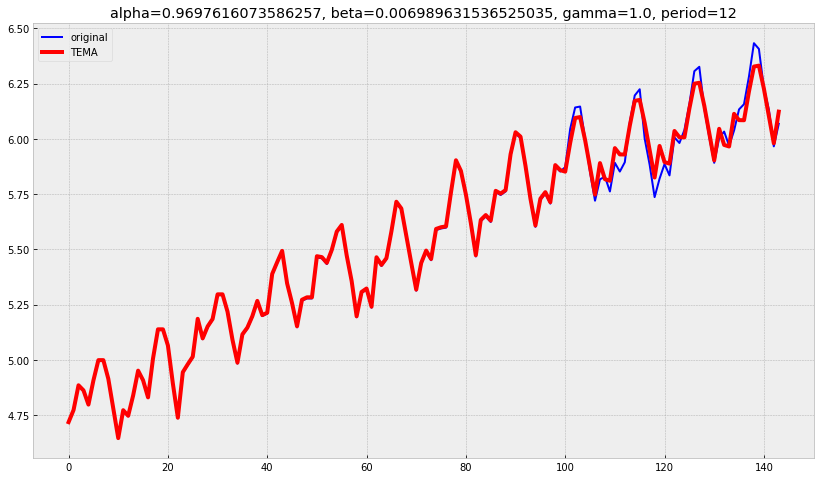

In [50]:
plot_tema(opt.x[0], opt.x[1], opt.x[2], best_i, train, series, len(test))

# Резуьтаты стали сильно лучше

Алгоритмы двойного и тройного экспоненциального сглаживания были выбраны из-за лучших предсказаний на длинных дистанциях. 